In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import re
import json
import requests
import subprocess
import glob
import os
import geopandas as gpd
from geopandas import GeoDataFrame
from pygeocoder import Geocoder

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
tow = pd.read_csv('/Users/elizabethclick/Desktop/DATA205/tow_clean.csv')
tow.drop(tow[tow['hh_income'] < 0].index, inplace = True)
tow.head()

,tow_date,tow_reason,storage_company,street,city,geo_location,longitude,latitude,location,block,hh_income,pop_total,pop_black,tract
0,2020-12-11,REPO,Final Notice,21704 Stableview Dr,Gaithersburg,POINT (-77.175624 39.211873),-77.175624,39.211873,"(39.211873, -77.175624)",7001012,208929,1931,39,700101
1,2021-02-10,REPO,Thomas,7321 Brink Rd,Gaithersburg,POINT (-77.148754 39.211605),-77.148754,39.211605,"(39.211605, -77.148754)",7001013,135208,800,10,700101
2,2020-02-15,REPO,Greenwood Recovery,21400 Laytonsville Rd,Gaithersburg,POINT (-77.141329 39.207148),-77.141329,39.207148,"(39.207148, -77.141329)",7001032,218173,1017,193,700103
3,2020-02-04,REPO,Greenwood Recovery,7571 Lindbergh Dr,Gaithersburg,POINT (-77.153158 39.166038),-77.153158,39.166038,"(39.166038, -77.153158)",7001033,172778,3112,345,700103
4,2020-02-08,NOP,Henrys,17604 Phelps Hill Ln,Derwood,POINT (-77.145388 39.147122),-77.145388,39.147122,"(39.147122, -77.145388)",7001033,172778,3112,345,700103


In [118]:
print(tow.shape)
print(tow[tow["storage_company"] == "Tcl"])

(18564, 14)
         tow_date tow_reason storage_company                  street  \
12     2020-08-02        PRV             Tcl  7501 Muncaster Mill Rd   
13     2020-08-12       FIRE             Tcl    17612 Phelps Hill Ln   
15     2020-12-20       REPO             Tcl  6314 Holland Meadow Ln   
76     2020-12-03       REPO             Tcl        9214 Chadburn Pl   
77     2020-12-11       REPO             Tcl       9410 Penshurst Ct   
...           ...        ...             ...                     ...   
18632  2020-04-05        NOP             Tcl       5401 Westbard Ave   
18665  2021-01-23       REPO             Tcl      12122 Bentridge Pl   
18752  2020-08-13        NOP             Tcl       10524 Westlake Dr   
18756  2020-12-10        NOP             Tcl       10405 Westlake Dr   
18764  2021-01-23       REPO             Tcl       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
12           Gaithersburg  POINT (-77.1535

In [123]:
#Set constants by dropping duplicte rows in another dataframe 
pop_sort = tow.sort_values(["block"]).drop_duplicates(subset = 'pop_total', keep='first').reset_index() 
#calculate total population using blocks data
mc_population = sum(pop_sort["pop_total"]) 
mc_blackpop = sum(pop_sort["pop_black"]) 
print('Total MC population = ', mc_population) 
print('Total MC black population = ', mc_blackpop)
pop_sort["pop_white"] = pop_sort["pop_total"] - pop_sort["pop_black"]

#total city populations: reger back to this dataframe and sum the blocks pop_sort city_names = pd.Series(pop_sort['city'].unique()) city_names
city_melt = pd.melt(pop_sort, id_vars="city", value_vars=["pop_total", "pop_black", "pop_white"], var_name=None, value_name='value', col_level=None, ignore_index=True)
city_popvals = city_melt.groupby(["city","variable"]).agg(sum_col=pd.NamedAgg(column="value", aggfunc="sum")) 

city_popvals = city_popvals.reset_index()
print(city_popvals)
city_popvals = city_popvals.pivot(index='city', columns=["variable"])
#city_popvals = pd.DataFrame(city_popvals)
#city_popvalsdf = pd.DataFrame(reshaped_city_popvals)
#city_popvalsdf = city_popvalsdf.columns.droplevel(0)
city_names = pd.Series(city_popvals.index)
city_names



Total MC population =  786495
Total MC black population =  170033
                  city   variable  sum_col
0             Bethesda  pop_black     2436
1             Bethesda  pop_total    38705
2             Bethesda  pop_white    36269
3                Boyds  pop_black      754
4                Boyds  pop_total     5762
5                Boyds  pop_white     5008
6          Brookeville  pop_black      162
7          Brookeville  pop_total     3004
8          Brookeville  pop_white     2842
9         Burtonsville  pop_black     6320
10        Burtonsville  pop_total    13031
11        Burtonsville  pop_white     6711
12          Cabin John  pop_black      142
13          Cabin John  pop_total     2121
14          Cabin John  pop_white     1979
15         Chevy Chase  pop_black      580
16         Chevy Chase  pop_total     9901
17         Chevy Chase  pop_white     9321
18          Clarksburg  pop_black     4508
19          Clarksburg  pop_total    25340
20          Clarksburg  pop_whi

0               Bethesda
1                  Boyds
2            Brookeville
3           Burtonsville
4             Cabin John
5            Chevy Chase
6             Clarksburg
7               Damascus
8                Derwood
9           Gaithersburg
10          Garrett Park
11            Germantown
12            Kensington
13    Montgomery Village
14                 Olney
15           Poolesville
16               Potomac
17             Rockville
18         Silver Spring
19           Takoma Park
Name: city, dtype: object

In [5]:
test = np.array(city_popvals)
df_test = pd.DataFrame(test)
df_test
df_test = df_test.rename(columns = {0 : "pop_black",
                            1 : "pop_total",
                            2 : "pop_white"})
df_test["city"] = ['Bethesda', 'Boyds', 'Brookeville', 'Burtonsville', 'Cabin John',
       'Chevy Chase', 'Clarksburg', 'Damascus', 'Derwood', 'Gaithersburg',
       'Garrett Park', 'Germantown', 'Kensington', 'Montgomery Village',
       'Olney', 'Poolesville', 'Potomac', 'Rockville', 'Silver Spring',
       'Takoma Park']
df_test

,pop_black,pop_total,pop_white,city
0,2436,38705,36269,Bethesda
1,754,5762,5008,Boyds
2,162,3004,2842,Brookeville
3,6320,13031,6711,Burtonsville
4,142,2121,1979,Cabin John
5,580,9901,9321,Chevy Chase
6,4508,25340,20832,Clarksburg
7,1247,11548,10301,Damascus
8,1606,14939,13333,Derwood
9,19441,113598,94157,Gaithersburg


In [126]:
## WHAT AREAS EXPERIENCE THE MOST TOWING
#subset cities with over 200 towings for the year
tow_city=tow['city'].value_counts()#[tow['city'].value_counts()> 200]
city_count = tow["city"].value_counts()
city_freq = tow["city"].value_counts(normalize = True)
#make a new dataframe with values from counts and city population values above
city_df = pd.DataFrame(tow_city, tow_city.index)
city_df = city_df.rename(columns={'city': 'tow_count'})

city_df = city_df.reset_index()
city_df = city_df.rename(columns={'index': 'city'})
print(city_df)
print(df_test)
city_uniform = city_df.merge(right = df_test, how='inner', on="city", left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

city_uniform["tow_rate"] = city_uniform["tow_count"] / city_uniform["pop_total"]
city_uniform

                  city  tow_count
0        Silver Spring       7950
1         Gaithersburg       3045
2           Germantown       2333
3            Rockville       1792
4   Montgomery Village       1637
5             Bethesda        531
6         Burtonsville        303
7          Takoma Park        276
8             Damascus        157
9              Derwood        149
10               Olney        133
11         Chevy Chase        115
12          Kensington         57
13          Clarksburg         42
14             Potomac         29
15               Boyds          6
16         Brookeville          4
17         Poolesville          3
18          Cabin John          1
19        Garrett Park          1
    pop_black  pop_total  pop_white                city
0        2436      38705      36269            Bethesda
1         754       5762       5008               Boyds
2         162       3004       2842         Brookeville
3        6320      13031       6711        Burtonsville
4     

,city,tow_count,pop_black,pop_total,pop_white,tow_rate
0,Silver Spring,7950,80568,258571,178003,0.030746
1,Gaithersburg,3045,19441,113598,94157,0.026805
2,Germantown,2333,20993,80803,59810,0.028873
3,Rockville,1792,14725,114256,99531,0.015684
4,Montgomery Village,1637,7199,33094,25895,0.049465
5,Bethesda,531,2436,38705,36269,0.013719
6,Burtonsville,303,6320,13031,6711,0.023252
7,Takoma Park,276,3689,10477,6788,0.026343
8,Damascus,157,1247,11548,10301,0.013595
9,Derwood,149,1606,14939,13333,0.009974


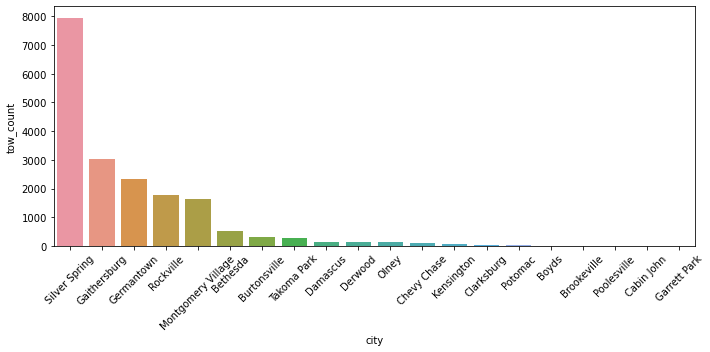

In [127]:
#visualization of towing by city: Chose top 8 to examine further
sns.barplot(x="city", y="tow_count", data = city_uniform)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

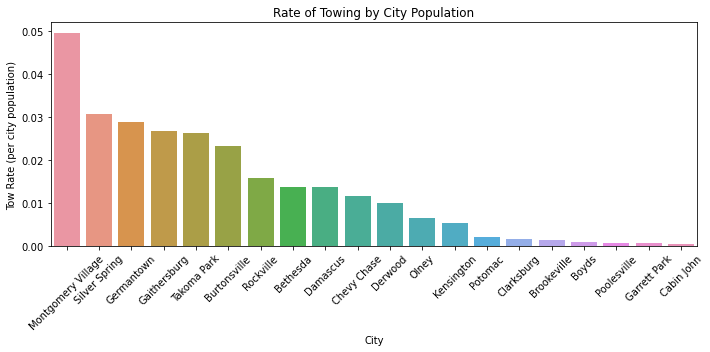

In [179]:
#visualization of towing by city: Chose top 8 to examine further
city_uniform = city_uniform.sort_values(by = ["tow_rate"], ascending=False)
sns.barplot(x="city", y="tow_rate", data = city_uniform)
plt.title("Rate of Towing by City Population")
plt.xlabel("City")
plt.ylabel("Tow Rate (per city population)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [129]:
##WHAT IS THE MOST COMMON REASON FOR TOWING?
tow_code=tow['tow_reason'].value_counts(normalize = True)[tow['tow_reason'].value_counts(normalize = True)> 0.0099]
reason_count = tow["tow_reason"].value_counts()
reason_freq = tow["tow_reason"].value_counts(normalize = True)
print(reason_freq)
tow_code


NOP                          0.510989
PKG                          0.201304
PRV                          0.088559
REPO                         0.072452
FIRE                         0.055699
                               ...   
HANDICAPPED PKG NO PERMIT    0.000054
PARKED IN SERERVED SPACE     0.000054
INOP                         0.000054
VISTOR PARKING VIOLATION     0.000054
CA                           0.000054
Name: tow_reason, Length: 212, dtype: float64


NOP     0.510989
PKG     0.201304
PRV     0.088559
REPO    0.072452
FIRE    0.055699
EXP     0.027742
Name: tow_reason, dtype: float64

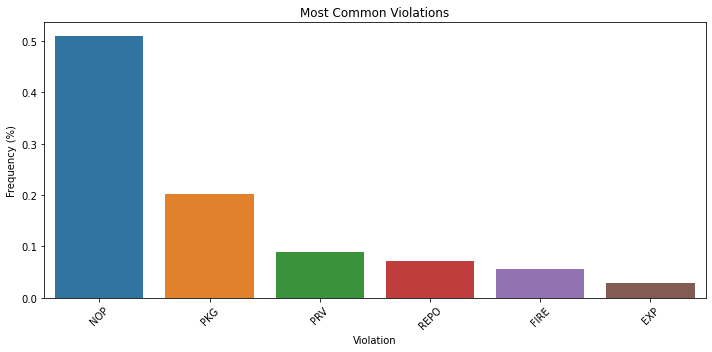

In [183]:
#visualization of towing by reason
sns.barplot(x=tow_code.index, y=tow_code)
plt.title("Most Common Violations")
plt.xlabel("Violation")
plt.ylabel("Frequency (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [131]:
##WHICH COMPANIES ARE TOWING AND ARE THERE DISCREPANCIES?
tow_company=tow['storage_company'].value_counts(normalize = True)[tow['storage_company'].value_counts(normalize = True)> 0.01]
company_count = tow["storage_company"].value_counts()
company_freq = tow["storage_company"].value_counts(normalize = True)
print(company_freq)
tow_company

Henrys                 0.317981
Authorized             0.163435
Prestige               0.087912
Speedy                 0.053167
Tcl                    0.045033
                         ...   
Jh Recovery            0.000054
Final Notice Towing    0.000054
Geenwood Recovery      0.000054
Tc L                   0.000054
Fitzgerald             0.000054
Name: storage_company, Length: 258, dtype: float64


Henrys         0.317981
Authorized     0.163435
Prestige       0.087912
Speedy         0.053167
Tcl            0.045033
Drive          0.044441
Diversified    0.026665
Auburn         0.023325
Big            0.021332
Custom         0.012497
Led            0.012497
Rickies        0.010181
Name: storage_company, dtype: float64

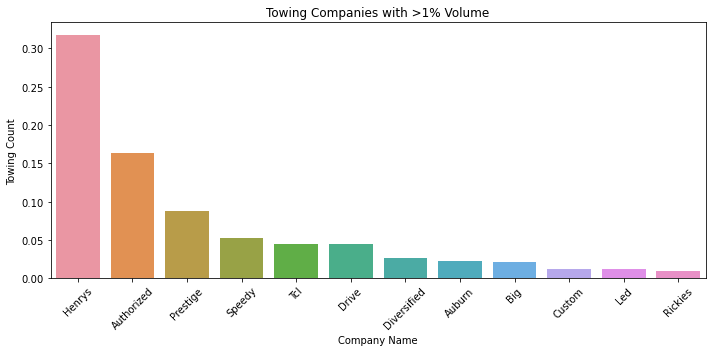

In [180]:
#Visualization of towing by company
sns.barplot(x=tow_company.index, y=tow_company)
plt.title("Towing Companies with >1% Volume")
plt.xlabel("Company Name")
plt.ylabel("Towing Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [133]:
#838 companies still listed as Tcl could not be identified
print(tow[tow["storage_company"] == "Tcl"])

         tow_date tow_reason storage_company                  street  \
12     2020-08-02        PRV             Tcl  7501 Muncaster Mill Rd   
13     2020-08-12       FIRE             Tcl    17612 Phelps Hill Ln   
15     2020-12-20       REPO             Tcl  6314 Holland Meadow Ln   
76     2020-12-03       REPO             Tcl        9214 Chadburn Pl   
77     2020-12-11       REPO             Tcl       9410 Penshurst Ct   
...           ...        ...             ...                     ...   
18632  2020-04-05        NOP             Tcl       5401 Westbard Ave   
18665  2021-01-23       REPO             Tcl      12122 Bentridge Pl   
18752  2020-08-13        NOP             Tcl       10524 Westlake Dr   
18756  2020-12-10        NOP             Tcl       10405 Westlake Dr   
18764  2021-01-23       REPO             Tcl       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
12           Gaithersburg  POINT (-77.153568 39.153681

In [134]:
#group company for each city - results in multi-index dataframe
grp1 =  tow.groupby(["storage_company", "city"]).agg(count_col=pd.NamedAgg(column="storage_company", aggfunc="count"))     
print(type(grp1))
grp1

<class 'pandas.core.frame.DataFrame'>


count_col
storage_company                 city                    
14505 Lee Hwy                   Silver Spring          1
301-562-4020                    Gaithersburg           1
3018779285                      Silver Spring          1
7908 Bellefonte Ln, Clinton, Md Gaithersburg           1
A & M                           Germantown             2
...                                                  ...
Vrs                             Potomac                1
                                Rockville              6
                                Silver Spring         17
                                Takoma Park            1
Vrs021920                       Silver Spring          1

[730 rows x 1 columns]

In [135]:
#flatten above df from multi-index to regular index
grp1 = grp1.reset_index()
grp1

,storage_company,city,count_col
0,14505 Lee Hwy,Silver Spring,1
1,301-562-4020,Gaithersburg,1
2,3018779285,Silver Spring,1
3,"7908 Bellefonte Ln, Clinton, Md",Gaithersburg,1
4,A & M,Germantown,2
...,...,...,...
725,Vrs,Potomac,1
726,Vrs,Rockville,6
727,Vrs,Silver Spring,17
728,Vrs,Takoma Park,1


In [185]:
#top 8 cities
city_list8 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville',
        'Montgomery Village', 'Bethesda', 'Burtonsville', 'Takoma Park']
city_list5 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville','Montgomery Village']

In [186]:
companies = ["Henrys", "Prestige", "Authorized", "Speedy", "Tcl"]
df5 = grp1.loc[grp1['storage_company'].isin(companies)]
#df5["total"] = int(count_col)
df5 = df5.loc[df5['city'].isin(city_list8)]
df5

,storage_company,city,count_col
96,Authorized,Bethesda,14
97,Authorized,Burtonsville,13
99,Authorized,Gaithersburg,460
100,Authorized,Germantown,406
101,Authorized,Montgomery Village,269
102,Authorized,Rockville,380
103,Authorized,Silver Spring,1452
104,Authorized,Takoma Park,19
368,Henrys,Bethesda,190
370,Henrys,Burtonsville,50


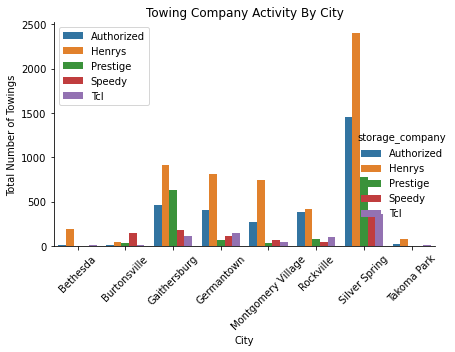

In [187]:
#Visualization of towing by company
sns.catplot(x="city", y="count_col", hue="storage_company", kind="bar", data=df5)
plt.xticks(rotation=45)
plt.title("Towing Company Activity By City")
plt.xlabel("City")
plt.ylabel("Total Number of Towings")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [139]:
#COMPARISON OF HOUSEHOLD INCOME BETWEEN CITIES; BOXPLOT FOR TOP 8.

In [140]:
#Create dataframe with demographics and geo only
tow_demo = tow.drop(columns = ["tow_date", "tow_reason", "storage_company", "street", "longitude", "latitude", "location", "tract"])
tow_demo["pop_white"] = tow_demo["pop_total"] - tow_demo["pop_black"]
print(tow_demo.head())
tow_demo.info()

           city                  geo_location    block  hh_income  pop_total  \
0  Gaithersburg  POINT (-77.175624 39.211873)  7001012     208929       1931   
1  Gaithersburg  POINT (-77.148754 39.211605)  7001013     135208        800   
2  Gaithersburg  POINT (-77.141329 39.207148)  7001032     218173       1017   
3  Gaithersburg  POINT (-77.153158 39.166038)  7001033     172778       3112   
4       Derwood  POINT (-77.145388 39.147122)  7001033     172778       3112   

   pop_black  pop_white  
0         39       1892  
1         10        790  
2        193        824  
3        345       2767  
4        345       2767  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18564 entries, 0 to 18766
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          18564 non-null  object
 1   geo_location  18564 non-null  object
 2   block         18564 non-null  int64 
 3   hh_income     18564 non-null  int64 
 4 

In [141]:
#show each city demo with countys of towing by block in tow_demo
city_grp = tow_demo.groupby(["city", "hh_income", "pop_total", "pop_black", "pop_white"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
print(city_grp)
city_grp = city_grp.reset_index() #flatten level
#put demo count by city in dataframe "city_df"
citygrp_df = pd.DataFrame(city_grp)
citygrp_df
citygrp_df["tow_rate"] = citygrp_df["count_col"] / citygrp_df["pop_total"]
citygrp_df["black_rate"] = citygrp_df["pop_black"] / citygrp_df["pop_total"]
#we can see that towing decreases as hh_income increases
print(citygrp_df[citygrp_df["city"] == "Germantown"])

                                                     count_col
city        hh_income pop_total pop_black pop_white           
Bethesda    56677     1203      313       890               64
            59205     1032      200       832               62
            62000     892       121       771               35
            64934     1237      221       1016              11
            70132     1335      235       1100               1
...                                                        ...
Takoma Park 98333     1653      467       1186              18
            106875    2104      401       1703              16
            122500    967       46        921                3
            137330    1360      233       1127               5
            152875    1282      273       1009               5

[501 rows x 1 columns]
           city  hh_income  pop_total  pop_black  pop_white  count_col  \
154  Germantown      44784       1505        364       1141        139   
155  Germ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 81 to 486
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        372 non-null    object 
 1   hh_income   372 non-null    int64  
 2   pop_total   372 non-null    int64  
 3   pop_black   372 non-null    int64  
 4   pop_white   372 non-null    int64  
 5   count_col   372 non-null    int64  
 6   tow_rate    372 non-null    float64
 7   black_rate  372 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 26.2+ KB
None
              city  hh_income  pop_total  pop_black  pop_white  count_col  \
81    Gaithersburg      42212        621         68        553         31   
82    Gaithersburg      47743       1560        263       1297         64   
83    Gaithersburg      50977       1693        416       1277         51   
84    Gaithersburg      54861       1375        585        790          8   
85    Gaithersburg      55037   

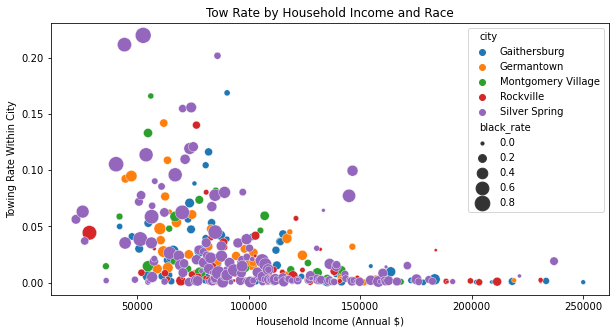

In [188]:
top5_demo = citygrp_df.loc[citygrp_df['city'].isin(city_list5)]
print(top5_demo.info())
print(top5_demo)

sns.scatterplot(x='hh_income', y='tow_rate', hue = "city", size = "black_rate", data=top5_demo, sizes=(10, 250))
#sns.scatterplot(data=data, x="gdpPercap", y="lifeExp", size="pop", legend=False, sizes=(20, 2000))
plt.title("Tow Rate by Household Income and Race")
plt.xlabel("Household Income (Annual $)")
plt.ylabel("Towing Rate Within City")
plt.show()
#WE CAN CLEARLY SEE THAT THE LOWER INCOME TOWINGS (RATE = COUNT/CITY POPULATION) APPEAR EXCESSIVE FOR TOP 5 TOWED CITIES
#WE CAN ALSO SEE THE LOWEST INCOME RATES EXPERIENCING EXCESSIVE TOWING ARE AS HIGH AS 80% BLACK POPULATIONS; 
#THIS IS WHAT SYSTEMIC RACISM LOOKS LIKE

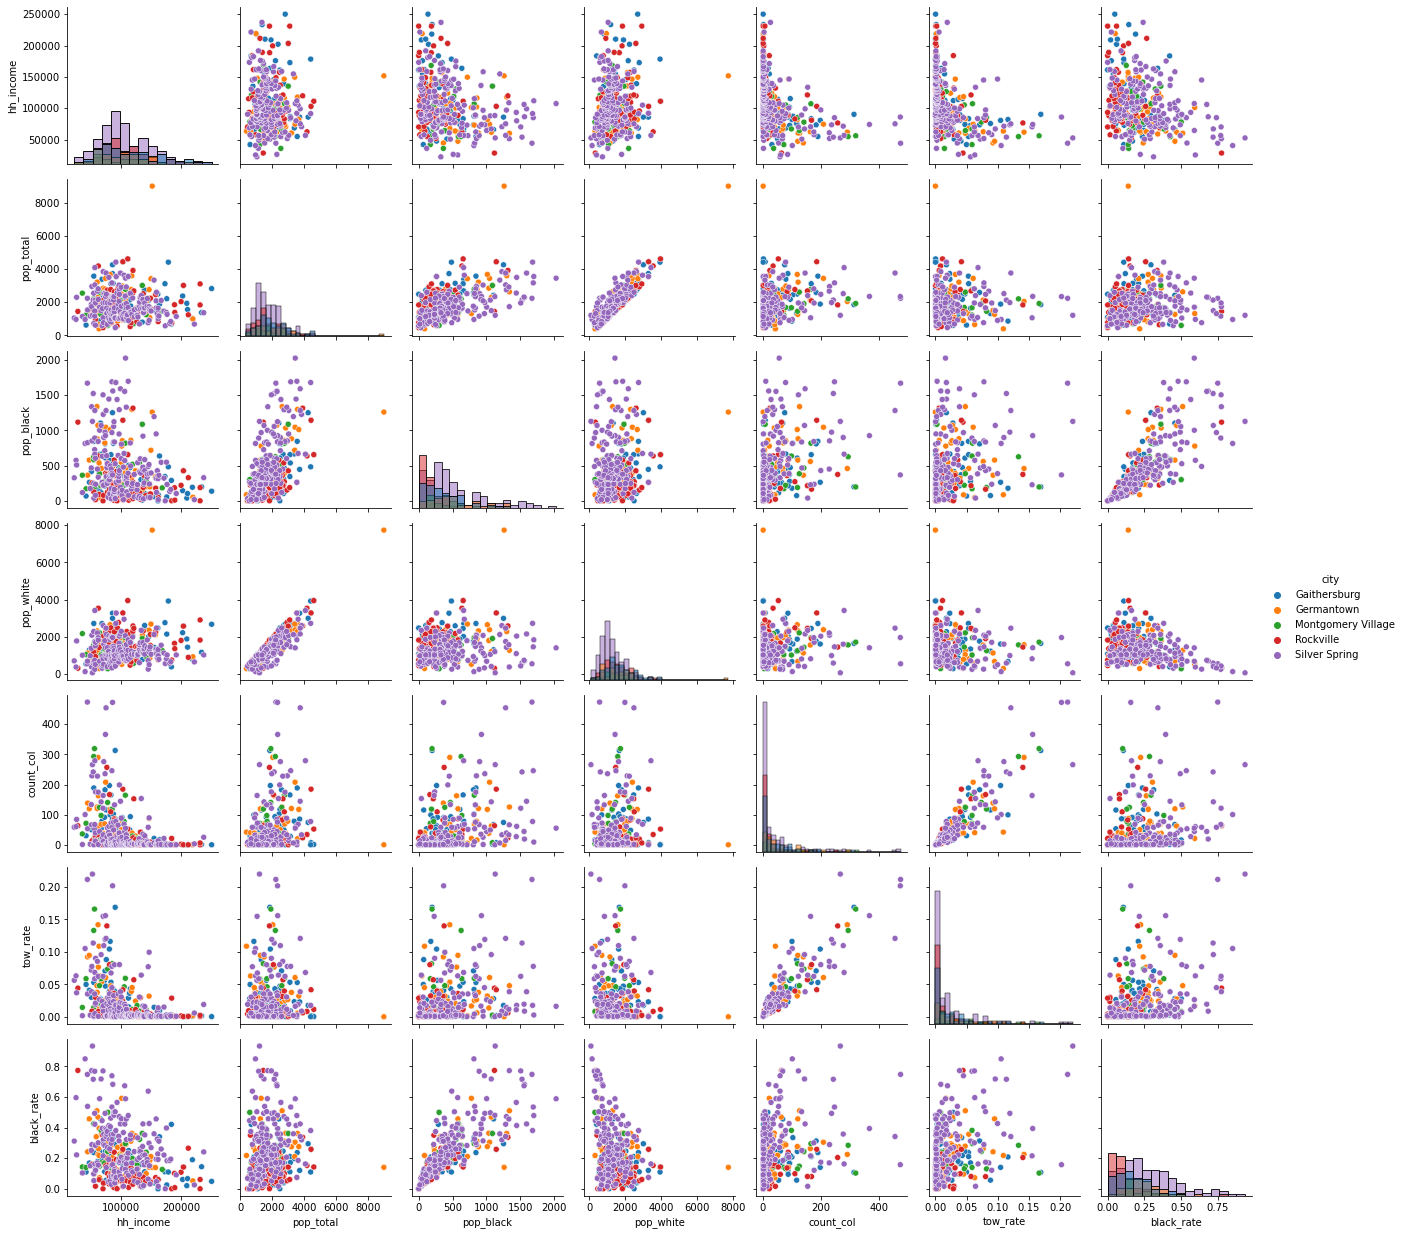

In [143]:
g = sns.PairGrid(top5_demo, hue="city")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [159]:
#Independent Dataframes by City
btc = citygrp_df[citygrp_df['city']=="Bethesda"]
btb = citygrp_df[citygrp_df['city']=="Burtonsville"]
gbc = citygrp_df[citygrp_df['city']=="Gaithersburg"]
gtc = citygrp_df[citygrp_df['city']=="Germantown"]
mvc = citygrp_df[citygrp_df['city']=="Montgomery Village"]
rvc = citygrp_df[citygrp_df['city']=="Rockville"]
ssc = citygrp_df[citygrp_df['city']=="Silver Spring"]
tpc = citygrp_df[citygrp_df["city"]=="Takoma Park"]
print(sum(rvc["tow_rate"]))
gbc


0.872269162409625


,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
81,Gaithersburg,42212,621,68,553,31,0.049919,0.109501
82,Gaithersburg,47743,1560,263,1297,64,0.041026,0.168590
83,Gaithersburg,50977,1693,416,1277,51,0.030124,0.245718
84,Gaithersburg,54861,1375,585,790,8,0.005818,0.425455
85,Gaithersburg,55037,3568,845,2723,189,0.052971,0.236827
...,...,...,...,...,...,...,...,...
148,Gaithersburg,208929,1931,39,1892,1,0.000518,0.020197
149,Gaithersburg,210179,1557,103,1454,1,0.000642,0.066153
150,Gaithersburg,218173,1017,193,824,1,0.000983,0.189774
151,Gaithersburg,233362,1376,198,1178,2,0.001453,0.143895


In [160]:
#TEST IF INCOME IN PAIRED CITIES HAVE THE SAME DISTRIBUTION OR ARE DIFFERENT
#H_0: THEY HAVE THE SAME DISTRIBUTIONS
#H_alpha: THEY HAVE DIFFERENT DISTRIBUTIONS
#alpha = 0.95

#For Germantown/Rockville, alpha >0.05; reject the null 
#For Germantown and other 3 pairings, cannot reject the null

In [161]:
#Mann Whitney U Test ; just Germantown for now
import scipy.stats
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(gbc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1197.0, pvalue=0.013933673911651656)

In [162]:
scipy.stats.mannwhitneyu(mvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=437.0, pvalue=0.26352631490975137)

In [163]:
scipy.stats.mannwhitneyu(rvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=839.0, pvalue=8.054677497790453e-06)

In [164]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=2684.0, pvalue=0.006966963005601298)

In [150]:
#LOGISTIC REGRESSION

In [151]:
#GET p1, p2, p2, p4, p5 FOR THE TOP 5 TO COMPARE H_O: all equal, or H_alph: at least one is not equal; alpha = .05
#Compute probability of getting towed by household income within each city



In [168]:
block_grp =  tow_demo.groupby(["block", "city", "hh_income", "pop_total", "pop_black", "pop_white", "geo_location"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
block_grp = block_grp.reset_index()
#put demo count by city in dataframe "block_df"
block_df = pd.DataFrame(block_grp)
block_df["tow_rate"] = block_df["count_col"] / block_df["pop_total"]
block_df

,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate
0,7001012,Gaithersburg,208929,1931,39,1892,POINT (-77.175624 39.211873),1,0.000518
1,7001013,Gaithersburg,135208,800,10,790,POINT (-77.148754 39.211605),1,0.001250
2,7001032,Gaithersburg,218173,1017,193,824,POINT (-77.141329 39.207148),1,0.000983
3,7001033,Derwood,172778,3112,345,2767,POINT (-77.144138 39.147034),1,0.000321
4,7001033,Derwood,172778,3112,345,2767,POINT (-77.144806 39.147649),2,0.000643
...,...,...,...,...,...,...,...,...,...
5624,7060123,Bethesda,59205,1032,200,832,POINT (-77.149295 39.024606),14,0.013566
5625,7060123,Bethesda,59205,1032,200,832,POINT (-77.152166 39.026407),1,0.000969
5626,7060123,Bethesda,59205,1032,200,832,POINT (-77.152171 39.026405),10,0.009690
5627,7060123,Bethesda,59205,1032,200,832,POINT (-77.152785 39.026129),1,0.000969


In [169]:
btb = block_df[block_df['city']=="Bethesda"]
bvb = block_df[block_df['city']=="Burtonsville"]
gbb = block_df[block_df['city']=="Gaithersburg"]
gtb = block_df[block_df['city']=="Germantown"]
mvb = block_df[block_df['city']=="Montgomery Village"]
rvb = block_df[block_df['city']=="Rockville"]
ssb = block_df[block_df['city']=="Silver Spring"]
tpb = block_df[block_df['city']=="Takoma Park"]
print("Gaithersburg", gbb.describe())
print("Germantown", gtb.describe())
print("Montgomery_Village", mvb.describe())
print("Rockville", rvb.describe())
print("Silver Spring", ssb.describe())
btb



Gaithersburg               block      hh_income    pop_total    pop_black    pop_white  \
count  9.040000e+02     904.000000   904.000000   904.000000   904.000000   
mean   7.007283e+06   91465.609513  2260.887168   433.152655  1827.734513   
std    1.301076e+03   29465.597668   808.410250   259.006704   661.442630   
min    7.001012e+06   42212.000000   602.000000     0.000000   301.000000   
25%    7.007161e+06   73580.000000  1634.000000   235.000000  1310.000000   
50%    7.007201e+06   85966.000000  2231.000000   370.000000  1776.000000   
75%    7.008161e+06  103092.000000  2722.000000   608.000000  2284.000000   
max    7.013071e+06  250001.000000  4606.000000  1252.000000  3950.000000   

        count_col    tow_rate  
count  904.000000  904.000000  
mean     3.368363    0.001729  
std     13.044788    0.007183  
min      1.000000    0.000217  
25%      1.000000    0.000401  
50%      1.000000    0.000596  
75%      2.000000    0.001090  
max    284.000000    0.153182  
Germa

,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate
3174,7012053,Bethesda,124554,762,33,729,POINT (-77.126068 39.025879),19,0.024934
3175,7012053,Bethesda,124554,762,33,729,POINT (-77.126521 39.0286),1,0.001312
3176,7012053,Bethesda,124554,762,33,729,POINT (-77.127605 39.029056),2,0.002625
3177,7012053,Bethesda,124554,762,33,729,POINT (-77.127756 39.029152),3,0.003937
3178,7012053,Bethesda,124554,762,33,729,POINT (-77.128016 39.029317),38,0.049869
...,...,...,...,...,...,...,...,...,...
5624,7060123,Bethesda,59205,1032,200,832,POINT (-77.149295 39.024606),14,0.013566
5625,7060123,Bethesda,59205,1032,200,832,POINT (-77.152166 39.026407),1,0.000969
5626,7060123,Bethesda,59205,1032,200,832,POINT (-77.152171 39.026405),10,0.009690
5627,7060123,Bethesda,59205,1032,200,832,POINT (-77.152785 39.026129),1,0.000969


In [167]:
#GET p1, p2, p2, p4, p5 FOR THE CITY TO COMPARE H_O: all equal, or H_alph: at least one is not equal; alpha = .05
#Compute population total each city using block data



      block  pop_total  count_col
0   7001012       1931          1
1   7001013        800          1
2   7001032       1017          1
3   7001033       3112          6
4   7001041       2619          1
..      ...        ...        ...
67  7008281       2209          2
68  7008291       1500          3
69  7008292       1762          5
70  7008331       1678         12
71  7013071       4409          1

[72 rows x 3 columns]
      block  pop_total  count_col
0   7002051       8987          1
1   7003041        941         10
2   7003043       2251          2
3   7003044       2792         44
4   7003062       3591         18
5   7003063       2762         12
6   7003081       1361          9
7   7003082       1854          5
8   7003083        887         34
9   7003084       2165          7
10  7003091       2976         51
11  7003092       2624         35
12  7003101       3670         17
13  7003102        651         12
14  7003103       1289         17
15  7003104       1067   

sum    22581
Name: pop_total, dtype: int64

Text(0, 0.5, 'Household Income')

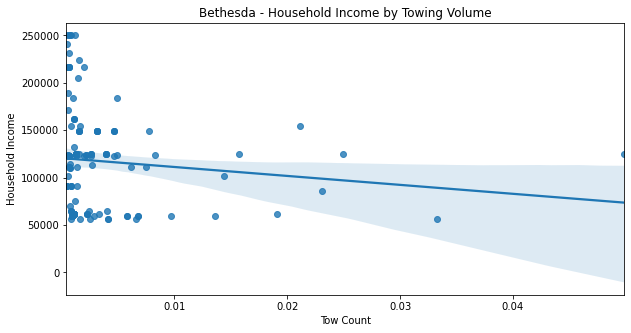

In [170]:
sns.regplot(x = "tow_rate", y = "hh_income", data = btb)
plt.title("Bethesda - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

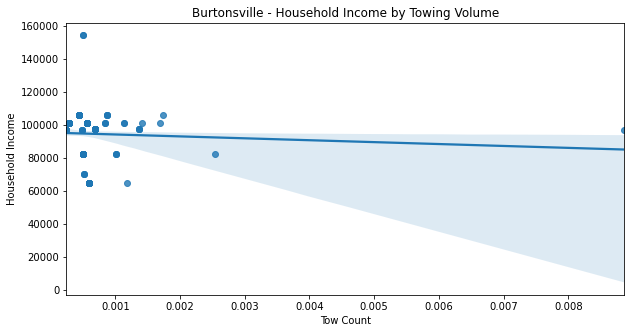

In [171]:
sns.regplot(x = "tow_rate", y = "hh_income", data = bvb)
plt.title("Burtonsville - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

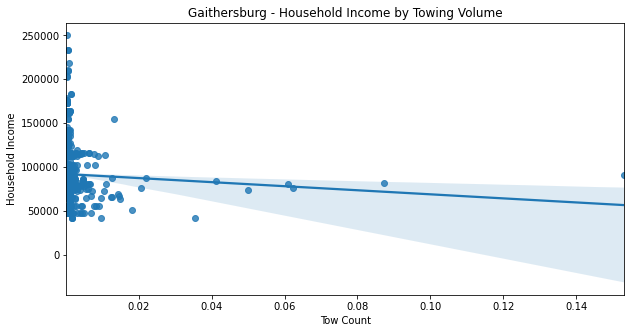

In [172]:
sns.regplot(x = "tow_rate", y = "hh_income", data = gbb)
plt.title("Gaithersburg - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

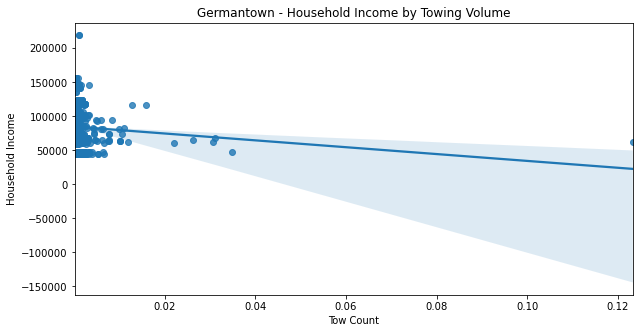

In [173]:
sns.regplot(x = "tow_rate", y = "hh_income", data = gtb)
plt.title("Germantown - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

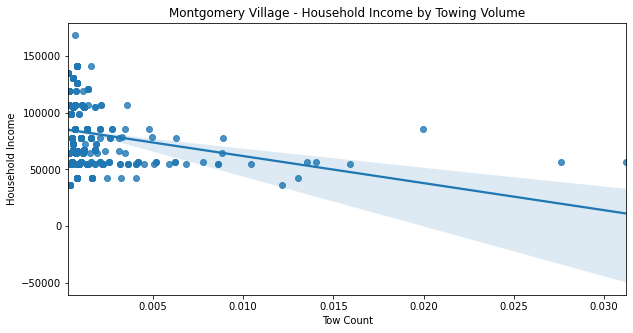

In [174]:
sns.regplot(x = "tow_rate", y = "hh_income", data = mvb)
plt.title("Montgomery Village - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

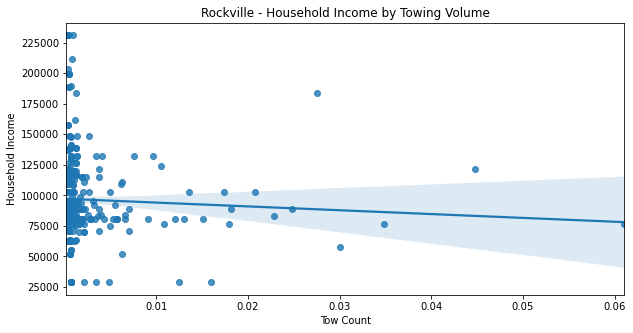

In [175]:
sns.regplot(x = "tow_rate", y = "hh_income", data = rvb)
plt.title("Rockville - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

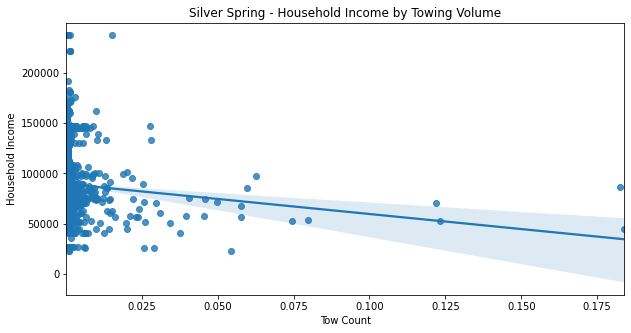

In [176]:
sns.regplot(x = "tow_rate", y = "hh_income", data = ssb)
plt.title("Silver Spring - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

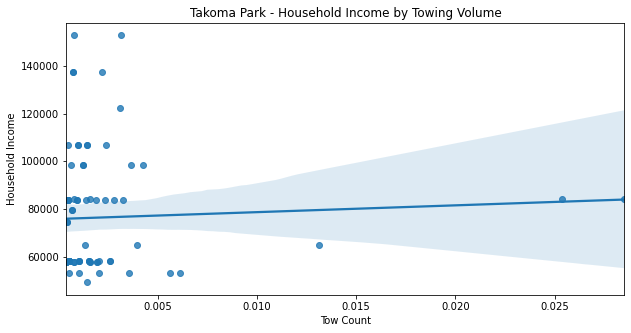

In [177]:
sns.regplot(x = "tow_rate", y = "hh_income", data = tpb)
plt.title("Takoma Park - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")